## Load Training Data

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import Imputer
from sklearn.utils import resample
train_data = pd.read_csv("equip_failures_training_set.csv")
train_data.head()

,id,target,sensor1_measure,sensor2_measure,sensor3_measure,sensor4_measure,sensor5_measure,sensor6_measure,sensor7_histogram_bin0,sensor7_histogram_bin1,sensor7_histogram_bin2,sensor7_histogram_bin3,sensor7_histogram_bin4,sensor7_histogram_bin5,sensor7_histogram_bin6,sensor7_histogram_bin7,sensor7_histogram_bin8,sensor7_histogram_bin9,sensor8_measure,sensor9_measure,sensor10_measure,sensor11_measure,sensor12_measure,sensor13_measure,sensor14_measure,sensor15_measure,sensor16_measure,sensor17_measure,sensor18_measure,sensor19_measure,sensor20_measure,sensor21_measure,sensor22_measure,sensor23_measure,sensor24_histogram_bin0,sensor24_histogram_bin1,sensor24_histogram_bin2,sensor24_histogram_bin3,sensor24_histogram_bin4,sensor24_histogram_bin5,...,sensor77_measure,sensor78_measure,sensor79_measure,sensor80_measure,sensor81_measure,sensor82_measure,sensor83_measure,sensor84_measure,sensor85_measure,sensor86_measure,sensor87_measure,sensor88_measure,sensor89_measure,sensor90_measure,sensor91_measure,sensor92_measure,sensor93_measure,sensor94_measure,sensor95_measure,sensor96_measure,sensor97_measure,sensor98_measure,sensor99_measure,sensor100_measure,sensor101_measure,sensor102_measure,sensor103_measure,sensor104_measure,sensor105_histogram_bin0,sensor105_histogram_bin1,sensor105_histogram_bin2,sensor105_histogram_bin3,sensor105_histogram_bin4,sensor105_histogram_bin5,sensor105_histogram_bin6,sensor105_histogram_bin7,sensor105_histogram_bin8,sensor105_histogram_bin9,sensor106_measure,sensor107_measure
0,1,0,76698,na,2130706438,280,0,0,0,0,0,0,37250,1432864,3664156,1007684,25896,0,2551696,0,0,0,0,0,4933296,3655166,1766008,1132040,0,0,0,0,1012,268,0,0,0,0,0,469014,...,18,5330690,4732,1126,0,0,0,0,0,0,0,0,62282,85908,32790,0,0,202710,37928,14745580,1876644,0,0,0,0,2801180,2445.8,2712,965866,1706908,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,2,0,33058,na,0,na,0,0,0,0,0,0,18254,653294,1720800,516724,31642,0,1393352,0,68,0,0,0,2560898,2127150,1084598,338544,0,0,0,0,0,0,0,0,0,0,0,71510,...,na,na,3312,522,0,0,0,0,0,0,0,0,33736,36946,5936,0,0,103330,16254,4510080,868538,0,0,0,0,3477820,2211.76,2334,664504,824154,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,3,0,41040,na,228,100,0,0,0,0,0,0,1648,370592,1883374,292936,12016,0,1234132,0,0,0,0,0,2371990,2173634,300796,153698,0,0,0,0,358,110,0,0,0,0,0,0,...,0,2341048,1494,152,0,0,0,0,0,0,0,0,13876,38182,8138,0,0,65772,10534,300240,48028,0,0,0,0,1040120,1018.64,1020,262032,453378,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,4,0,12,0,70,66,0,10,0,0,0,318,2212,3232,1872,0,0,0,2668,0,0,0,642,3894,10184,7554,10764,1014,0,0,0,0,60,6,0,0,0,0,0,0,...,0,2578,76,62,0,0,0,0,0,0,0,0,232,0,0,2014,370,48,18,15740,1822,20174,44,0,0,0,1.08,54,5670,1566,240,46,58,44,10,0,0,0,4,32
4,5,0,60874,na,1368,458,0,0,0,0,0,0,43752,1966618,1800340,131646,4588,0,1974038,0,226,0,0,0,3230626,2618878,1058136,551022,0,0,0,0,1788,642,0,0,0,0,42124,372236,...,0,3590004,2026,444,0,0,0,0,0,0,0,0,44946,62648,11506,0,0,149474,35154,457040,80482,98334,27588,0,0,21173050,1116.06,1176,404740,904230,622012,229790,405298,347188,286954,311560,433954,1218,0,0


In [0]:
import matplotlib.pyplot as plt


## Data Preparation
- Replacing NaNs with 0s


In [0]:
for col in train_data.columns:
    train_data[col] = train_data[col].replace("na", 0).astype(float)

df_majority = train_data.loc[train_data['target'] == 0]
df_minority = train_data.loc[train_data['target'] == 1] 

No handles with labels found to put in legend.


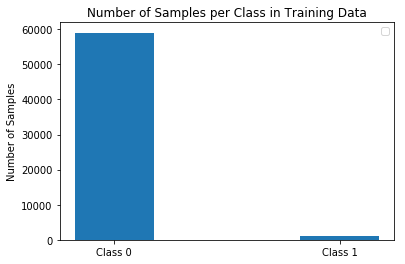

In [7]:
labels = ['Class 0', 'Class 1']
num_samples = [len(df_majority), len(df_minority)]
width = 0.35

x = np.arange(len(labels)) 
fig, ax = plt.subplots()
rects1 = ax.bar(x, num_samples, width)

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel('Number of Samples')
ax.set_title('Number of Samples per Class in Training Data')
ax.legend()


## Data Preparation 
- Upsampling Required to counter the skewness 

In [0]:
df_minority_upsampled = resample(df_minority, replace=True,n_samples=40000,random_state=123) # reproducible results
df_upsampled = pd.concat([df_majority, df_minority_upsampled]) 

No handles with labels found to put in legend.


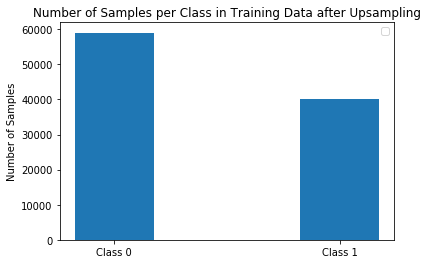

In [52]:
labels = ['Class 0', 'Class 1']
num_samples = [len(df_majority), len(df_minority_upsampled)]
width = 0.35

x = np.arange(len(labels)) 
fig, ax = plt.subplots()
rects1 = ax.bar(x, num_samples, width)

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel('Number of Samples')
ax.set_title('Number of Samples per Class in Training Data after Upsampling')
ax.legend()

Since classes numbers are comparable we can proceed with prediction algorithm

## Extract Labels and Features for Training and Testing

In [0]:
labels = df_upsampled["target"]
features_out = df_upsampled.drop(["id","target"],axis=1)

### Data Normalization per Sensor

In [0]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
scaler.fit(features_out)
X_scaled = scaler.transform(features_out)

### Split into Train and Test 

In [0]:
# labels = labels.values.tolabels = labels.values.tolist()
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, np.asarray(labels), test_size=0.3, random_state=0)

## Create Model for Training

In [13]:
from tensorflow.python.keras.layers import Dense,Dropout
from tensorflow.python.keras.models import Sequential
from keras.utils import plot_model
model = Sequential([
    Dense(1000, activation='relu'),
    Dropout(0.2),
    Dense(500, activation='relu'),
    Dropout(0.2),
    Dense(100, activation='relu'),
    Dense(10, activation='relu'),
    Dense(1, activation='sigmoid'),
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',])


Using TensorFlow backend.


### Begin Training and save the model

In [14]:
history = model.fit(X_train, y_train, epochs=10, batch_size=256)
model.save("Datathon_conocco_philip.h5")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 69300 samples
Epoch 1/10
69300/69300 [==============================] - 10s 145us/sample - loss: 0.1374 - acc: 0.9542
Epoch 2/10
69300/69300 [==============================] - 10s 139us/sample - loss: 0.0826 - acc: 0.9738
Epoch 3/10
69300/69300 [==============================] - 10s 141us/sample - loss: 0.0649 - acc: 0.9808
Epoch 4/10
69300/69300 [==============================] - 10s 140us/sample - loss: 0.0548 - acc: 0.9843
Epoch 5/10
69300/69300 [==============================] - 10s 140us/sample - loss: 0.0482 - acc: 0.9863
Epoch 6/10
69300/69300 [==============================] - 10s 140us/sample - loss: 0.0431 - acc: 0.9875
Epoch 7/10
69300/69300 [==============================] - 10s 140us/sample - loss: 0.0407 - acc: 0.9879
Epoch 8/10
69300/69300 [==============================] - 10s 140us/sample

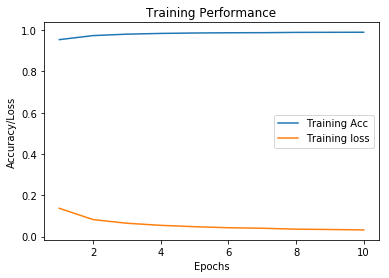

In [15]:
history_dict = history.history
history_dict.keys()
import matplotlib.pyplot as plt

acc = history.history['acc']
loss = history.history['loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, acc, label='Training Acc')
# b is for "solid blue line"
plt.plot(epochs, loss,label='Training loss')
plt.title('Training Performance')
plt.xlabel('Epochs')
plt.ylabel('Accuracy/Loss')
plt.legend()

plt.show()


## Get predictions and the F-1 Score

In [0]:
preds = model.predict(X_test)
preds2 = np.array([int(i>=0.9) for i in preds])
from sklearn.metrics import f1_score
score = f1_score(y_test,preds2,average =None )
score

array([0.9965335 , 0.99657361])

### Load Test Data

In [0]:
test_data = pd.read_csv("equip_failures_test_set.csv")

### Pre-Process test data just like train data

In [0]:
ids_test = test_data["id"]
features_out_test = test_data.drop(["id"],axis=1)

for col in features_out_test.columns:
    features_out_test[col] = features_out_test[col].replace("na", 0).astype(float)
x_test_scaled = scaler.transform(features_out_test)

## Get Predictions for test data

In [0]:
y_final = model.predict(x_test_scaled)
y_final = np.array([int(i>=0.9) for i in y_final])

### Create CSV file for submission

In [0]:
final_df = pd.DataFrame.from_dict({'id': ids_test , 'target' : y_final})
final_df.to_csv('submission.csv',index=False)

### Save the scaler

In [21]:
from sklearn.externals import joblib 
joblib.dump(scaler, 'minmaxscaler.pkl') 

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


['minmaxscaler.pkl']

## Interpreting the results with XGboost

In [22]:
!pip install xgboost


In [28]:
from xgboost.sklearn import XGBClassifier
model = XGBClassifier(objective="binary:hinge", max_depth=8, n_estimators=50)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=50, n_jobs=1,
              nthread=None, objective='binary:hinge', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

## Visualize with SHAP
### Display the top 10 features that influence the prediction of the model based on Shapley values

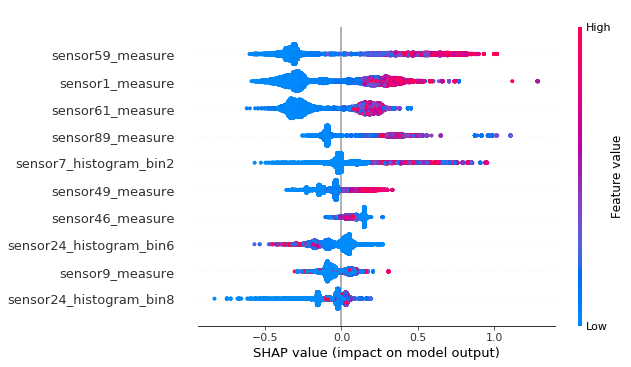

In [29]:
import shap
shap.initjs()
shap_values = shap.TreeExplainer(model).shap_values(X_test)
shap.summary_plot(shap_values, X_test,feature_names=features_out.columns.values.tolist(),max_display=10)

## Reproducibilty

In [33]:
scores1 = []
from sklearn.metrics import f1_score

model = Sequential([
    Dense(1000, activation='relu'),
    Dropout(0.2),
    Dense(500, activation='relu'),
    Dropout(0.2),
    Dense(100, activation='relu'),
    Dense(10, activation='relu'),
    Dense(1, activation='sigmoid'),
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',])

for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, labels.to_numpy(), test_size=0.3,random_state=1)
    model.fit(X_train, y_train, epochs=100, batch_size=256)
    preds = model.predict(X_test)
    preds2 = np.array([int(i>0.5) for i in preds])
    score = f1_score(y_test,preds2)
    scores1.append(score)

Train on 69300 samples
69300/69300 [==============================] - 10s 145us/sample - loss: 0.1449 - acc: 0.9535
Train on 69300 samples
69300/69300 [==============================] - 11s 162us/sample - loss: 0.0871 - acc: 0.9721
Train on 69300 samples
69300/69300 [==============================] - 10s 142us/sample - loss: 0.0676 - acc: 0.9798
Train on 69300 samples
69300/69300 [==============================] - 10s 141us/sample - loss: 0.0588 - acc: 0.9821
Train on 69300 samples
69300/69300 [==============================] - 10s 139us/sample - loss: 0.0505 - acc: 0.9853
Train on 69300 samples
69300/69300 [==============================] - 10s 148us/sample - loss: 0.0460 - acc: 0.9863
Train on 69300 samples
69300/69300 [==============================] - 10s 140us/sample - loss: 0.0410 - acc: 0.9880
Train on 69300 samples
69300/69300 [==============================] - 10s 142us/sample - loss: 0.0375 - acc: 0.9888
Train on 69300 samples
69300/69300 [==============================] - 10

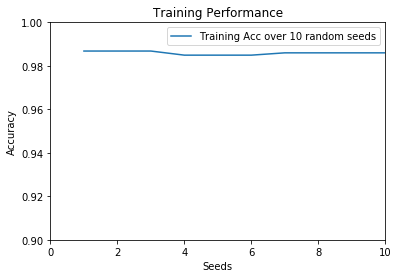

In [51]:
epochs = range(1, len(scores1) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, scores1, label='Training Acc over 10 random seeds')
# b is for "solid blue line"
plt.title('Training Performance')
plt.xlabel('Seeds')
plt.ylabel('Accuracy')
plt.legend()
plt.axis([0,10,0.9,1])
plt.show()